In [1]:
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import GroupKFold, KFold
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import warnings
from itertools import combinations
import math


warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

targets = pd.read_csv('../input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))


In [2]:


columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1))
        .fill_null(0)
        .clip(0, 1e9)
        .over(["session_id", "level"])
        .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1))
        .abs()
        .over(["session_id", "level"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col("text").fill_null("text_None")

]

CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff', 'fullscreen', 'hq', 'music']
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]




def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).max().alias(f'word_max_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c
          in DIALOGS],
        #text_v2
        *[pl.col('text_code').filter(pl.col('text_code') == c).count().alias(f'{c}_text_code_counts{feature_suffix}') for c in test_list],
        *[pl.col("elapsed_time_diff").filter((pl.col('text_code') == c)).mean().alias(f'{c}_text_mean_{feature_suffix}') for c in
          test_list],
        *[pl.col("elapsed_time_diff").filter((pl.col('text_code') == c)).std().alias(f'{c}_text_std_{feature_suffix}') for c in
          test_list],
        *[pl.col("elapsed_time_diff").filter((pl.col('text_code') == c)).max().alias(f'{c}_text_max_{feature_suffix}') for c in
          test_list],
        *[pl.col("elapsed_time_diff").filter((pl.col('text_code') == c)).sum().alias(f'{c}_text_sum_{feature_suffix}') for c in
          test_list],
        *[pl.col("elapsed_time_diff").filter((pl.col('text_code') == c)).median().alias(f'{c}_text_median_{feature_suffix}') for c
          in test_list],
        
        
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],

        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}")
          for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}")
          for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).median().alias(f"{c}_ET_median_{feature_suffix}")
          for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).median().alias(
            f"{c}_ET_median_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c
          in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).median().alias(f"{c}_ET_median_{feature_suffix}") for
          c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(
            f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}")
          for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).median().alias(
            f"{c}_ET_median_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in
          level_groups],

    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    if use_extra:
        if grp == '5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text") == "Here's the log book.")
                                              | (pl.col("fqid") == 'logbook.page.bingo'))
                    .apply(lambda s: s.max() - s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(
                    (pl.col("text") == "Here's the log book.") | (pl.col("fqid") == 'logbook.page.bingo')).apply(
                    lambda s: s.max() - s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                            pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader')) | (
                        pl.col("fqid") == "reader.paper2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                            pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals')) | (
                        pl.col("fqid") == "journals.pic_2.bingo")).apply(lambda s: s.max() - s.min()).alias(
                    "journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp == '13-22':
            aggs = [
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'reader_flag')) | (
                            pl.col("fqid") == "tunic.library.microfiche.reader_flag.paper2.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(
                    ((pl.col("event_name") == 'navigate_click') & (pl.col("fqid") == 'journals_flag')) | (
                            pl.col("fqid") == "journals_flag.pic_0.bingo")).apply(
                    lambda s: s.max() - s.min() if s.len() > 0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()






In [3]:
# df = pl.read_csv('../input/predict-student-performance-from-game-play/train.csv').with_columns(columns)


# test_dict = dict(zip(sorted(list(df['text'].unique())),[f'text_{xx}' for xx in range(len(df['text'].unique()))]))
# test_list = sorted(list(df['text'].unique()))


In [4]:
import pickle
f_save = open('savedata/meta.pkl', 'rb')
[test_list,test_dict,importance_dict] = pickle.load(f_save)
f_save.close()

In [5]:
df1 = pd.read_pickle('df1.pkl')
df2 = pd.read_pickle('df2.pkl')
df3 = pd.read_pickle('df3.pkl')


# FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
# FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
# FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]


FEATURES1 = importance_dict['1']
FEATURES2 = importance_dict['6']
FEATURES3 = importance_dict['14']


print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3), 'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS), 'users info')

We will train with 178 278 294 features
We will train with 23562 users info


In [6]:
import lightgbm as lgb

feature_importance_df = pd.DataFrame()
models = {}
results = [[[], []] for _ in range(18)]
gkf = GroupKFold(n_splits=5)
oof_lgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_lgb_{i}' for i in range(1, 19)])
oof_lgb_fold = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_lgb_{i}' for i in range(1, 19)])

for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3

    FEATURES = importance_dict[str(q)]

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    seed1 = 42
    params1 = {
            'learning_rate': 0.02,        
            'lambda_l1': 2,
            'lambda_l2': 7,
            'num_leaves': 800,
            'min_sum_hessian_in_leaf': 20,
            'feature_fraction': 0.8,
            'feature_fraction_bynode': 0.8,
            'bagging_fraction': 0.9,
            'bagging_freq': 42,
            'min_data_in_leaf': 700,
            'max_depth': 5,
#             'categorical_column':[0],
            'seed': seed1,
            'feature_fraction_seed': seed1,
            'bagging_seed': seed1,
            'drop_seed': seed1,
            'data_random_seed': seed1,
            'objective': 'binary',
            'boosting': 'gbdt',
            'verbosity': -1,
            'n_jobs':-1,
        }
    feature_importance_df = pd.DataFrame()
    

    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = df.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = df.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]


        lgb_train = lgb.Dataset(train_x[FEATURES].astype('float32'), train_y['correct'].values)
        lgb_eval = lgb.Dataset(valid_x[FEATURES].astype('float32'), valid_y['correct'].values)
        model = lgb.Booster(model_file=f"savedata/fold{fold}_q{q}.lgb")
    
        y = valid_y
        y_hat = model.predict(valid_x[FEATURES])
        models[(fold, q)] = model
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = model.feature_importance()
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        oof_lgb.loc[valid_users,f'meta_lgb_{q}'] = y_hat
        oof_lgb_fold.loc[valid_users,f'meta_lgb_{q}'] = fold

        
        results[q - 1][0].append(y)
        results[q - 1][1].append(y_hat)
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
results = [[np.concatenate(_) for _ in _] for _ in results]


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

#########################
question1, with178features
#########################


  6%|████▌                                                                              | 1/18 [00:03<00:52,  3.07s/it]

#########################
question2, with235features
#########################


 11%|█████████▏                                                                         | 2/18 [00:05<00:44,  2.79s/it]

#########################
question3, with214features
#########################


 17%|█████████████▊                                                                     | 3/18 [00:08<00:39,  2.65s/it]

#########################
question4, with248features
#########################


 22%|██████████████████▍                                                                | 4/18 [00:11<00:38,  2.77s/it]

#########################
question5, with240features
#########################


 28%|███████████████████████                                                            | 5/18 [00:13<00:35,  2.70s/it]

#########################
question6, with278features
#########################


 33%|███████████████████████████▋                                                       | 6/18 [00:16<00:32,  2.68s/it]

#########################
question7, with274features
#########################


 39%|████████████████████████████████▎                                                  | 7/18 [00:18<00:29,  2.67s/it]

#########################
question8, with269features
#########################


 44%|████████████████████████████████████▉                                              | 8/18 [00:21<00:26,  2.65s/it]

#########################
question9, with274features
#########################


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:24<00:23,  2.64s/it]

#########################
question10, with234features
#########################


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:26<00:21,  2.63s/it]

#########################
question11, with266features
#########################


 61%|██████████████████████████████████████████████████                                | 11/18 [00:29<00:18,  2.62s/it]

#########################
question12, with276features
#########################


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:32<00:15,  2.63s/it]

#########################
question13, with225features
#########################


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:34<00:13,  2.61s/it]

#########################
question14, with294features
#########################


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:37<00:11,  2.77s/it]

#########################
question15, with281features
#########################


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:40<00:08,  2.73s/it]

#########################
question16, with321features
#########################


 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [00:42<00:05,  2.69s/it]

#########################
question17, with334features
#########################


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:45<00:02,  2.67s/it]

#########################
question18, with399features
#########################


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:48<00:00,  2.69s/it]


In [7]:
oof_fold = oof_lgb_fold.T.drop_duplicates().T.reset_index()
oof_fold.columns = ['session_id','fold']
oof_fold

,session_id,fold
0,20090312431273200,1.0
1,20090312433251036,0.0
2,20090312455206810,1.0
3,20090313091715820,2.0
4,20090313571836404,3.0
...,...,...
23557,22100215342220508,3.0
23558,22100215460321130,4.0
23559,22100217104993650,0.0
23560,22100219442786200,1.0


In [8]:
oof_lgb

,meta_lgb_1,meta_lgb_2,meta_lgb_3,meta_lgb_4,meta_lgb_5,meta_lgb_6,meta_lgb_7,meta_lgb_8,meta_lgb_9,meta_lgb_10,meta_lgb_11,meta_lgb_12,meta_lgb_13,meta_lgb_14,meta_lgb_15,meta_lgb_16,meta_lgb_17,meta_lgb_18
session_id,,,,,,,,,,,,,,,,,,
20090312431273200,0.957946,0.990432,0.980023,0.938146,0.776990,0.901551,0.873130,0.692334,0.839991,0.705804,0.891526,0.910783,0.312091,0.812345,0.789470,0.804376,0.816903,0.989234
20090312433251036,0.813040,0.994735,0.980091,0.408947,0.155998,0.370792,0.585067,0.345398,0.483162,0.205884,0.343705,0.693448,0.127848,0.289345,0.099513,0.584317,0.545072,0.649104
20090312455206810,0.846431,0.985862,0.972192,0.622562,0.631343,0.795095,0.679863,0.652731,0.774413,0.580547,0.765231,0.867424,0.521724,0.600759,0.231824,0.782565,0.799561,0.922038
20090313091715820,0.415076,0.981688,0.873330,0.905041,0.618709,0.837745,0.865253,0.591828,0.799239,0.521404,0.647693,0.919050,0.120056,0.757243,0.438904,0.699158,0.694306,0.971308
20090313571836404,0.976750,0.996813,0.993269,0.960642,0.844005,0.952053,0.899294,0.792557,0.921168,0.693825,0.782314,0.925756,0.494280,0.876879,0.641231,0.691431,0.758262,0.991034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215342220508,0.861319,0.991616,0.954236,0.875676,0.514751,0.800571,0.775980,0.620893,0.758131,0.422583,0.637026,0.908316,0.185724,0.803912,0.514925,0.722895,0.560570,0.959412
22100215460321130,0.472537,0.989067,0.875057,0.894618,0.459467,0.789431,0.617374,0.527661,0.697715,0.333626,0.739289,0.914403,0.164963,0.876397,0.652572,0.776803,0.811215,0.983526
22100217104993650,0.839028,0.992129,0.945165,0.915818,0.720601,0.915766,0.928033,0.646242,0.900442,0.594344,0.760140,0.928989,0.299200,0.808866,0.809580,0.768847,0.673447,0.989567


In [9]:
oof_cat = oof_lgb.copy()

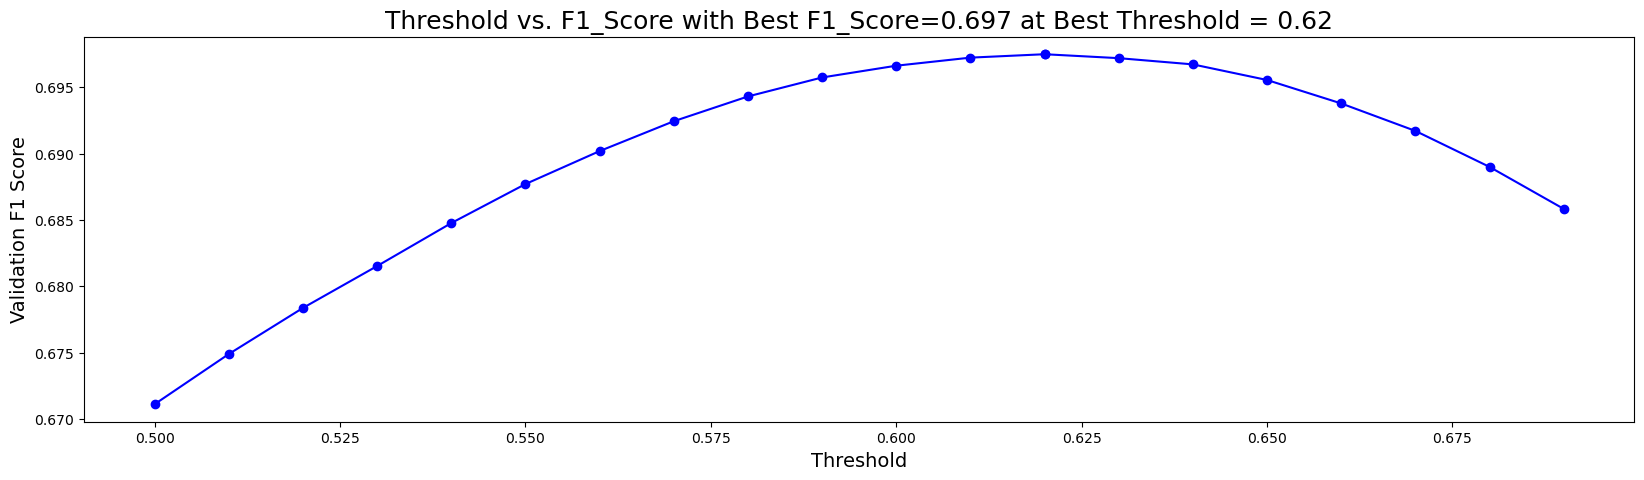

When using optimal threshold = 0.62...
Q0: F1 = 0.6766022527155394
Q1: F1 = 0.5042913292090969
Q2: F1 = 0.5054215883628179
Q3: F1 = 0.6801208074577139
Q4: F1 = 0.6382409642749631
Q5: F1 = 0.6433035031648764
Q6: F1 = 0.6296980997748729
Q7: F1 = 0.5718817183175567
Q8: F1 = 0.631917413965816
Q9: F1 = 0.5857993225513134
Q10: F1 = 0.6110545230367364
Q11: F1 = 0.5139104456102073
Q12: F1 = 0.4704540807822728
Q13: F1 = 0.6407377186575529
Q14: F1 = 0.6087771613049993
Q15: F1 = 0.5014427235333341
Q16: F1 = 0.5530969013092722
Q17: F1 = 0.4899126130287569
==> Overall F1 = 0.6974988090569093
s


In [10]:

true = pd.DataFrame(np.stack([_[0] for _ in results])[:,:,1].T).astype(float)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

scores = []; thresholds = []
best_socre = 0; best_threshold = 0

for threshold in np.arange(0.5, 0.7, 0.01):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, '-o', color='blue')
plt.scatter([best_threshold], [best_socre], color='blue')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier

feature_importance_df_stack = pd.DataFrame()
models_stack = {}
results_stack = [[[], []] for _ in range(18)]
oof_cat_stack = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])

for q in tqdm(range(1, 19)):
    if q <= 3:
        grp = '0-4'
        df = df1
        FEATURES = [f'meta_lgb_{xx}' for xx in [1,2,3]]

    elif q <= 13:
        grp = '5-12'
        df = df2
        FEATURES = [f'meta_lgb_{xx}' for xx in [1,2,3,4,5,6,7,8,9,10,11,12,13]]

    elif q <= 22:
        grp = '13-22'
        df = df3
        FEATURES = [f'meta_lgb_{xx}' for xx in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

    print("#"*25)
    print(f'question{q}, with{len(FEATURES)}features')
    print('#'*25)
    seed1 = 42
    params1 = {
            'learning_rate': 0.02,        
            'lambda_l1': 2,
            'lambda_l2': 7,
            'num_leaves': 800,
            'min_sum_hessian_in_leaf': 20,
            'feature_fraction': 0.8,
            'feature_fraction_bynode': 0.8,
            'bagging_fraction': 0.9,
            'bagging_freq': 42,
            'min_data_in_leaf': 700,
            'max_depth': 5,
            'seed': seed1,
            'feature_fraction_seed': seed1,
            'bagging_seed': seed1,
            'drop_seed': seed1,
            'data_random_seed': seed1,
            'objective': 'binary',
            'boosting': 'gbdt',
            'verbosity': -1,
            'n_jobs':-1,
        }
    
    feature_importance_df = pd.DataFrame()
    

    for fold, (train_idx, valid_idx) in enumerate(gkf.split(X=df, groups=df.index)):
        # TRAIN DATA
        train_x = oof_cat.iloc[train_idx]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q == q].set_index('session').loc[train_users]

        # VALID DATA
        valid_x = oof_cat.iloc[valid_idx]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q == q].set_index('session').loc[valid_users]



        lgb_train = lgb.Dataset(train_x[FEATURES].astype('float32'), train_y['correct'].values)
        lgb_eval = lgb.Dataset(valid_x[FEATURES].astype('float32'), valid_y['correct'].values)


        model = LogisticRegression(random_state=0).fit(train_x[FEATURES].astype('float32'), train_y['correct'].values)

        y = valid_y
        y_hat = model.predict_proba(valid_x[FEATURES])[:,1]
        models_stack[(fold, q)] = model

        oof_cat_stack.loc[valid_users,f'meta_{q}'] = y_hat

        
        results_stack[q - 1][0].append(y)
        results_stack[q - 1][1].append(y_hat)
results_stack = [[np.concatenate(_) for _ in _] for _ in results_stack]


import pickle
for (fold,q), model in models_stack.items():
    pickle.dump(model, open(f'savedata/fold{fold}_q{q}_stack.pkl', "wb"))


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

#########################
question1, with3features
#########################


  6%|████▌                                                                              | 1/18 [00:00<00:09,  1.88it/s]

#########################
question2, with3features
#########################


 11%|█████████▏                                                                         | 2/18 [00:00<00:05,  2.68it/s]

#########################
question3, with3features
#########################


 17%|█████████████▊                                                                     | 3/18 [00:01<00:05,  2.69it/s]

#########################
question4, with13features
#########################


 22%|██████████████████▍                                                                | 4/18 [00:01<00:07,  1.87it/s]

#########################
question5, with13features
#########################


 28%|███████████████████████                                                            | 5/18 [00:02<00:08,  1.48it/s]

#########################
question6, with13features
#########################


 33%|███████████████████████████▋                                                       | 6/18 [00:03<00:09,  1.32it/s]

#########################
question7, with13features
#########################


 39%|████████████████████████████████▎                                                  | 7/18 [00:04<00:08,  1.27it/s]

#########################
question8, with13features
#########################


 44%|████████████████████████████████████▉                                              | 8/18 [00:05<00:08,  1.23it/s]

#########################
question9, with13features
#########################


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:06<00:07,  1.21it/s]

#########################
question10, with13features
#########################


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:07<00:06,  1.18it/s]

#########################
question11, with13features
#########################


 61%|██████████████████████████████████████████████████                                | 11/18 [00:08<00:06,  1.13it/s]

#########################
question12, with13features
#########################


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:09<00:05,  1.15it/s]

#########################
question13, with13features
#########################


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:10<00:04,  1.12it/s]

#########################
question14, with18features
#########################


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:10<00:03,  1.09it/s]

#########################
question15, with18features
#########################


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:11<00:02,  1.08it/s]

#########################
question16, with18features
#########################


 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [00:12<00:01,  1.06it/s]

#########################
question17, with18features
#########################


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:14<00:00,  1.01it/s]

#########################
question18, with18features
#########################


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:14<00:00,  1.21it/s]


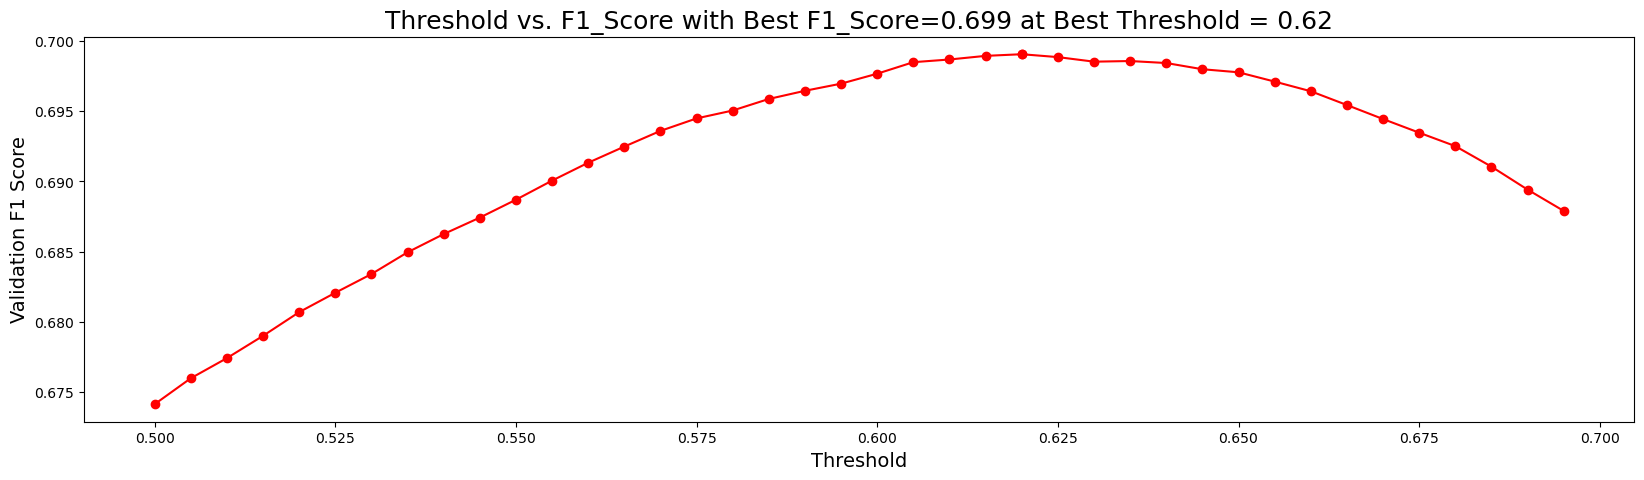

When using optimal threshold = 0.62...
Q0: F1 = 0.6737803833818216
Q1: F1 = 0.5154036827195467
Q2: F1 = 0.5185364908038981
Q3: F1 = 0.6796720550507007
Q4: F1 = 0.6495331766157358
Q5: F1 = 0.6507904491962276
Q6: F1 = 0.6314732167403754
Q7: F1 = 0.5763971105709833
Q8: F1 = 0.6322251129240821
Q9: F1 = 0.5974001422607369
Q10: F1 = 0.6163745004665071
Q11: F1 = 0.5195736797935515
Q12: F1 = 0.4860826534880322
Q13: F1 = 0.643268058460148
Q14: F1 = 0.6238374395135053
Q15: F1 = 0.50109282015434
Q16: F1 = 0.5544533155177993
Q17: F1 = 0.4906211416889717
==> Overall F1 = 0.6990453108490142
s


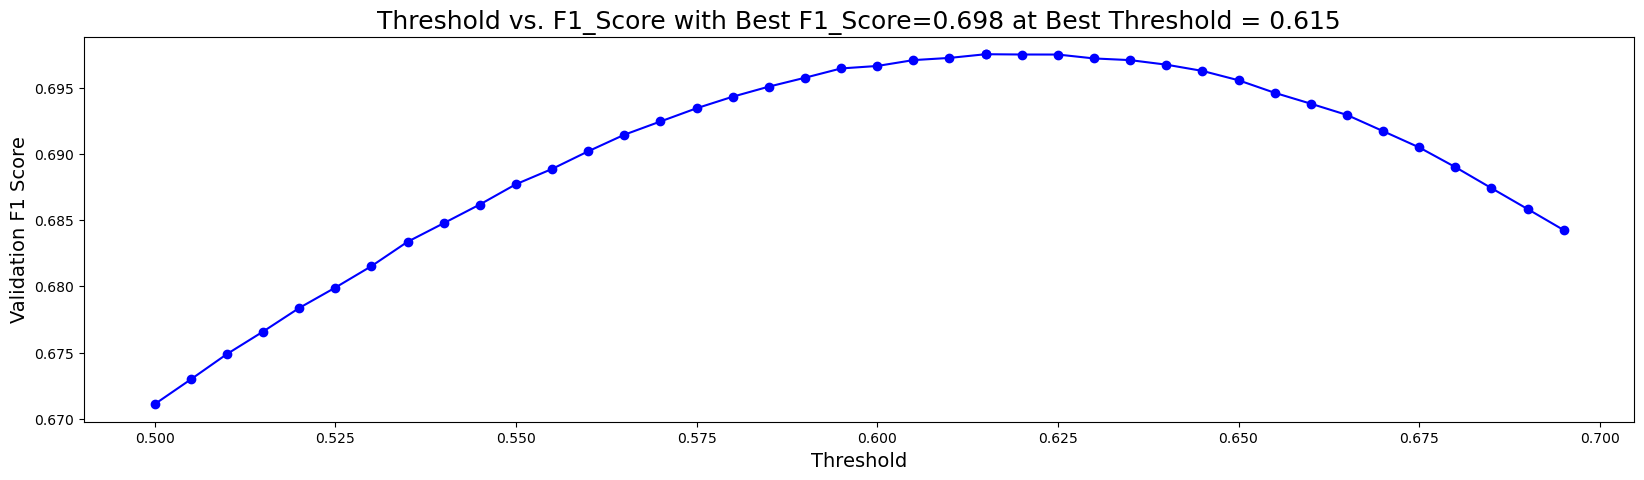

When using optimal threshold = 0.62...
Q0: F1 = 0.6765735505941706
Q1: F1 = 0.5042913292090969
Q2: F1 = 0.5043518230101176
Q3: F1 = 0.6802652858569534
Q4: F1 = 0.6413117917045439
Q5: F1 = 0.6428077999923206
Q6: F1 = 0.6278507757262041
Q7: F1 = 0.5748437838809822
Q8: F1 = 0.6300947170668502
Q9: F1 = 0.5907168024368963
Q10: F1 = 0.6109777276175283
Q11: F1 = 0.5107083812746247
Q12: F1 = 0.4741332142449218
Q13: F1 = 0.6400823025946947
Q14: F1 = 0.6126440572464208
Q15: F1 = 0.49643159083177774
Q16: F1 = 0.5479555540546552
Q17: F1 = 0.48904804118769946
==> Overall F1 = 0.6975201806449424
s


In [12]:

true = pd.DataFrame(np.stack([_[0] for _ in results_stack])[:,:,1].T).astype(float)
oof = pd.DataFrame(np.stack([_[1] for _ in results_stack]).T)

scores = []; thresholds = []
best_socre = 0; best_threshold = 0

for threshold in np.arange(0.5, 0.7, 0.005):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, '-o', color='red')
plt.scatter([best_threshold], [best_socre], color='red')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')


true = pd.DataFrame(np.stack([_[0] for _ in results])[:,:,1].T).astype(float)
oof = pd.DataFrame(np.stack([_[1] for _ in results]).T)

scores = []; thresholds = []
best_socre = 0; best_threshold = 0

for threshold in np.arange(0.5, 0.7, 0.005):
    preds = (oof.values.reshape(-1) > threshold).astype('int')
    m = f1_score(true.values.reshape(-1), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m > best_socre:
        best_socre = m
        best_threshold = threshold

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, '-o', color='blue')
plt.scatter([best_threshold], [best_socre], color='blue')
plt.xlabel("Threshold", size=14)
plt.ylabel("Validation F1 Score",size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score={best_socre:.3f} at Best Threshold = {best_threshold:.3}', size=18)
plt.show()

print(f'When using optimal threshold = {best_threshold:.2f}...')
for k in range(18):
    m = f1_score(true[k].values, (oof[k].values > best_threshold).astype('int'), average = 'macro')
    print(f'Q{k}: F1 =',m)
m = f1_score(true.values.reshape(-1), (oof.values > best_threshold).reshape(-1).astype('int'), average = 'macro')
print('==> Overall F1 =', m)
print('s')

In [13]:
from sklearn.linear_model import LogisticRegression
import pickle 
models_stack = [[pickle.load(open(f'savedata/fold{fold}_q{q}_stack.pkl', "rb")) for fold in range(5)] for q in range(1, 19)]
models_list = [[lgb.Booster(model_file= f"savedata/fold{fold}_q{q}.lgb") for fold in range(5)] for q in range(1, 19)]

In [14]:
f_save = open('dataall.pkl', 'wb')
sss = [test_list,test_dict,importance_dict,models_list,models_stack]
pickle.dump(sss, f_save)
f_save.close()